In [91]:
import pandas as pd

GSPC_2004 = pd.read_csv("GSPC_2004.csv")
GSPC_2005 = pd.read_csv("GSPC_2005.csv")
FIGRX_2004 = pd.read_csv("FIGRX_2004.csv")
FIGRX_2005 = pd.read_csv("FIGRX_2005.csv")
EURUSD_2004 = pd.read_csv("EURUSD_2004.csv")
EURUSD_2005 = pd.read_csv("EURUSD_2005.csv")


In [92]:
# preprocesseor
import numpy as np

GSPC_2004 = GSPC_2004[['Date', 'Close']]
GSPC_2004 = GSPC_2004.rename(columns={'Date': 'ds', 'Close': 'y'})

GSPC_2005 = GSPC_2005[['Date', 'Close']]
GSPC_2005 = GSPC_2005.rename(columns={'Date': 'ds', 'Close': 'y'})

FIGRX_2004 = FIGRX_2004[['Date', 'Close']]
FIGRX_2004 = FIGRX_2004.rename(columns={'Date': 'ds', 'Close': 'y'})

FIGRX_2005 = FIGRX_2005[['Date', 'Close']]
FIGRX_2005 = FIGRX_2005.rename(columns={'Date': 'ds', 'Close': 'y'})

data_2004=FIGRX_2004
data_2005=FIGRX_2005

data_2004['y']=np.log(data_2004['y'])

01:28:04 - cmdstanpy - INFO - Chain [1] start processing
01:28:04 - cmdstanpy - INFO - Chain [1] done processing
01:28:04 - cmdstanpy - INFO - Chain [1] start processing


Test RMSE: 0.0014356852007488506


01:28:05 - cmdstanpy - INFO - Chain [1] done processing
01:28:05 - cmdstanpy - INFO - Chain [1] start processing
01:28:05 - cmdstanpy - INFO - Chain [1] done processing
01:28:05 - cmdstanpy - INFO - Chain [1] start processing
01:28:05 - cmdstanpy - INFO - Chain [1] done processing
01:28:06 - cmdstanpy - INFO - Chain [1] start processing
01:28:06 - cmdstanpy - INFO - Chain [1] done processing
01:28:06 - cmdstanpy - INFO - Chain [1] start processing
01:28:06 - cmdstanpy - INFO - Chain [1] done processing
01:28:06 - cmdstanpy - INFO - Chain [1] start processing
01:28:06 - cmdstanpy - INFO - Chain [1] done processing
01:28:07 - cmdstanpy - INFO - Chain [1] start processing
01:28:07 - cmdstanpy - INFO - Chain [1] done processing
01:28:07 - cmdstanpy - INFO - Chain [1] start processing
01:28:07 - cmdstanpy - INFO - Chain [1] done processing
01:28:07 - cmdstanpy - INFO - Chain [1] start processing
01:28:07 - cmdstanpy - INFO - Chain [1] done processing
01:28:08 - cmdstanpy - INFO - Chain [1] 

Best model RMSE on test set: 0.001391207138931956
changepoint_prior_scale : 0.05
seasonality_prior_scale : 1.0
holidays_prior_scale : 0.01


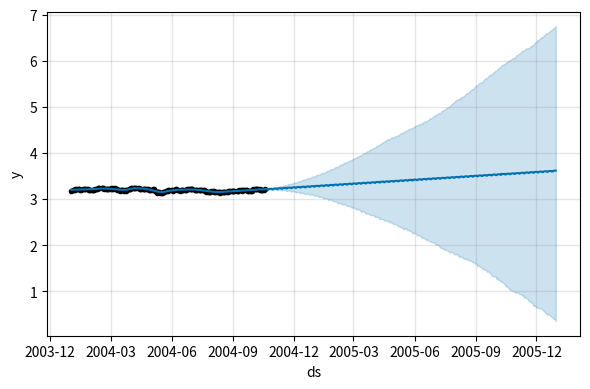

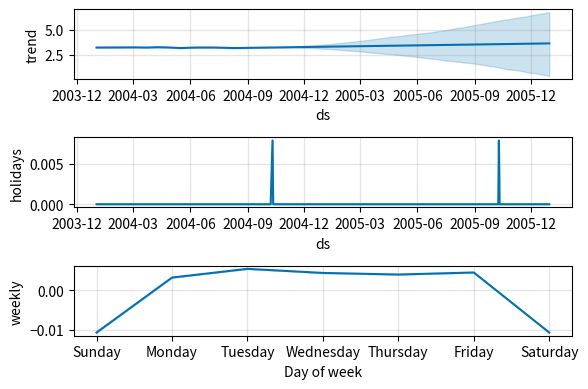

In [93]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import mean_squared_error
from prophet import Prophet

train_data, test_data = train_test_split(data_2004, test_size=0.2, shuffle=False)

model = Prophet(daily_seasonality=0.05)
model.add_country_holidays(country_name='US')
model.fit(train_data)
test_forecast = model.predict(test_data)
mse_test = mean_squared_error(test_data['y'], test_forecast['yhat'])
print(f'Test mse: {mse_test}')

param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.05, 0.1, 0.5, 1.0],
}

best_model = model
best_mse = mse_test

param_list = list(ParameterSampler(param_grid, n_iter=10, random_state=42))

for params in param_list:
    model = Prophet(**params)
    model.add_country_holidays(country_name='US')
    model.fit(train_data)
    test_forecast = model.predict(test_data)
    mse_test = mean_squared_error(test_data['y'], test_forecast['yhat'])

    if mse_test < best_mse:
        best_mse = mse_test
        best_model = model

print(f'Best model mse on test set: {best_mse}')

print(f'changepoint_prior_scale : {best_model.changepoint_prior_scale}')
print(f'seasonality_prior_scale : {best_model.seasonality_prior_scale}')
print(f'holidays_prior_scale : {best_model.holidays_prior_scale}')


future = best_model.make_future_dataframe(periods=437)
forecast = best_model.predict(future)
fig = best_model.plot(forecast, figsize=(6, 4))
fig = best_model.plot_components(forecast, figsize=(6, 4))


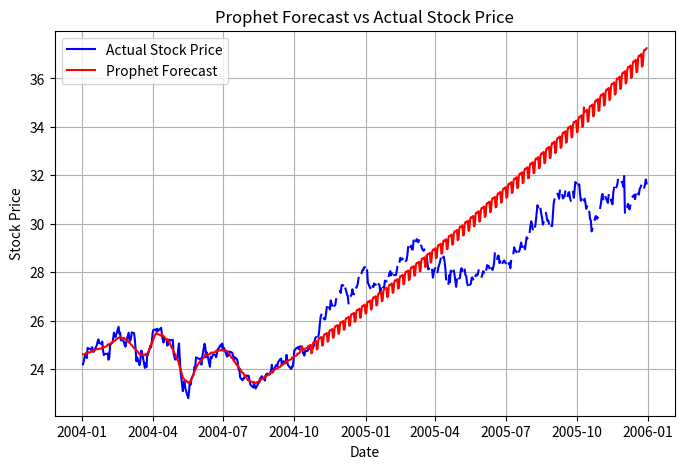

In [94]:
forecast=forecast[['ds','yhat']]
forecast['yhat']=np.exp(forecast['yhat'])
data_2004['y']=np.exp(data_2004['y'])

data_2004['ds'] = pd.to_datetime(data_2004['ds'])
data_2005['ds'] = pd.to_datetime(data_2005['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])
data_2004.set_index('ds', inplace=True)
data_2005.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

merged_data = data_2004.join(forecast, how='outer', rsuffix='_forecast')
merged_data = data_2005.join(merged_data, how='outer', rsuffix='_forecast')
merged_data.reset_index(inplace=True)
merged_data['y'].fillna(merged_data['y_forecast'], inplace=True)
merged_data=merged_data.drop(['y_forecast'],axis=1)

plt.figure(figsize=(8, 5))
plt.plot(merged_data['ds'], merged_data['y'], label='Actual Stock Price', color='blue')
plt.plot(merged_data['ds'], merged_data['yhat'], label='Prophet Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Prophet Forecast vs Actual Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
from sklearn import metrics

merged_data = merged_data.dropna()

two_years_AE = (merged_data['yhat'] - merged_data['y'])
print(two_years_AE.describe())
print ("MSE:",metrics.mean_squared_error(merged_data['yhat'], merged_data['y']))

count    504.000000
mean       1.085995
std        1.882517
min       -1.569343
25%       -0.223933
50%        0.151804
75%        2.620947
max        5.893020
dtype: float64
MSE: 4.716225243279897
